In [1]:
"""
=======================================================================================
# This code runs with model.py, and process Video_16_3_2.mp4 with GT+Pred bounding box;
# Originally adapted in March, modified in Sep.
- Draw boxes
- Model deplyment
- Video Generation
LOG: Sep. 26th we're testing the baseline with EAST model, test it on ICDAR 2013
     Oct. 6th run script on remote cluster 
=======================================================================================
"""
import cv2
import os
import time
import datetime
import numpy as np
import uuid
import json
import functools
import logging
import collections
import argparse
import tensorflow as tf
# my own modules
import _init_paths
import matplotlib
matplotlib.use('Agg')
from utils.icdar import restore_rectangle
import lanms
from utils.eval import resize_image, sort_poly, detect
from utils.icdar import load_annotations_solo, check_and_validate_polys
from utils.nms_highlevel import intersection
from lstm.model_rnn_east1 import ArrayModel
from config.configrnn import get_config

import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

############ Macros ############
BASIC = "basic"
CUDNN = "cudnn"
BLOCK = "block"
CONV  = "conv2d"
CUDNN_INPUT_LINEAR_MODE = "linear_input"
CUDNN_RNN_BIDIRECTION   = "bidirection"
CUDNN_RNN_UNIDIRECTION = "unidirection"
#
flags = tf.flags
flags.DEFINE_string("system", "local", "deciding running env")
flags.DEFINE_boolean('restore', True, 'whether to resotre from checkpoint')
flags.DEFINE_boolean('partially_restore', False, 'whether to restore the weights of back-bone')
flags.DEFINE_string("model", "test", "A type of model. Possible options are: small, medium, large.")
flags.DEFINE_integer("num_gpus", 1, "Larger than 1 will create multiple training replicas")
flags.DEFINE_string("rnn_mode", CONV, "one of CUDNN: BASIC, BLOCK")
flags.DEFINE_boolean('vis', False, "whether we would use plt")
flags.DEFINE_integer('running_count', 0, "know how many times we have run the model")

FLAGS = flags.FLAGS

/home/lxiaol9/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
print(cv2.__version__)

3.4.0


In [3]:

# used for iou searching and selecting TP, FP, FN #
def eval_single_frame(target, box):
    """
    input params:
        target, python ordered dict
        box, sorted boxes dict from predictions
    """
    TP   = 0
    FP   = 0
    FN   = 0
    precision = 0
    recall = 0
    F_measure = 0
    if not len(box['text_lines']) == 0:
        for t in target:
            d = np.array(t, dtype='int32')
            is_best = 0
            for m in box['text_lines']:
                n = np.array([m['x0'], m['y0'], m['x1'], m['y1'], m['x2'],
                              m['y2'], m['x3'], m['y3']], dtype='int32')

                # pick out the best match
                iou = intersection(n, d)
                if iou>is_best:
                    is_best = iou
            if is_best > 0.5:
                TP = TP+1
            elif is_best == 0:
                FN = FN +1
            else:
                FP = FP+1
        if TP > 0:
            precision = TP/(TP+FP)
            recall    = TP/(TP+FN)
            F_measure = 2*precision*recall/(precision+recall)
    return precision, recall, F_measure


def draw_illu(illu, rst):
    for t in rst['text_lines']:
        d = np.array([t['x0'], t['y0'], t['x1'], t['y1'], t['x2'],
                      t['y2'], t['x3'], t['y3']], dtype='int32')
        d = d.reshape(-1, 2)
        cv2.polylines(illu, [d], isClosed=True, thickness=2, color=(0, 255, 0))
    return illu


def draw_illu_gt(illu, rst, p, r, f):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.3
    fontColor = (255, 255, 255)
    lineType = 1
    infos = 'Precision ' + str(p)+ ', recall ' + str(r) + ', F_measure ' + str(f)
    cv2.putText(illu, infos,
                (2, 20),
                font,
                0.5,
                (255, 0, 0),
                lineType)
    for t in rst:
        d1 = t.reshape(-1, 2).astype(np.int32)
        cv2.polylines(illu, [d1], isClosed=True, thickness=2, color=(0, 0, 0))
        # bottomLeftCornerOfText = (int(t['x0']), int(t['y0']))

    return illu



resnet_v1_50/block1 (?, ?, ?, 256)
resnet_v1_50/block2 (?, ?, ?, 512)
resnet_v1_50/block3 (?, ?, ?, 1024)
resnet_v1_50/block4 (?, ?, ?, 2048)
Shape of f_0 (?, ?, ?, 2048)
Shape of f_1 (?, ?, ?, 512)
Shape of f_2 (?, ?, ?, 256)
Shape of f_3 (?, ?, ?, 64)
Shape of h_0 (?, ?, ?, 2048), g_0 (?, ?, ?, 2048)
Shape of h_1 (?, ?, ?, 128), g_1 (?, ?, ?, 128)
Shape of h_2 (?, ?, ?, 64), g_2 (?, ?, ?, 64)
Shape of h_3 (?, ?, ?, 32), g_3 (?, ?, ?, 32)
resnet_v1_50/block1 (?, ?, ?, 256)
resnet_v1_50/block2 (?, ?, ?, 512)
resnet_v1_50/block3 (?, ?, ?, 1024)
resnet_v1_50/block4 (?, ?, ?, 2048)
Shape of f_0 (?, ?, ?, 2048)
Shape of f_1 (?, ?, ?, 512)
Shape of f_2 (?, ?, ?, 256)
Shape of f_3 (?, ?, ?, 64)
Shape of h_0 (?, ?, ?, 2048), g_0 (?, ?, ?, 2048)
Shape of h_1 (?, ?, ?, 128), g_1 (?, ?, ?, 128)
Shape of h_2 (?, ?, ?, 64), g_2 (?, ?, ?, 64)
Shape of h_3 (?, ?, ?, 32), g_3 (?, ?, ?, 32)
resnet_v1_50/block1 (?, ?, ?, 256)
resnet_v1_50/block2 (?, ?, ?, 512)
resnet_v1_50/block3 (?, ?, ?, 1024)
resnet

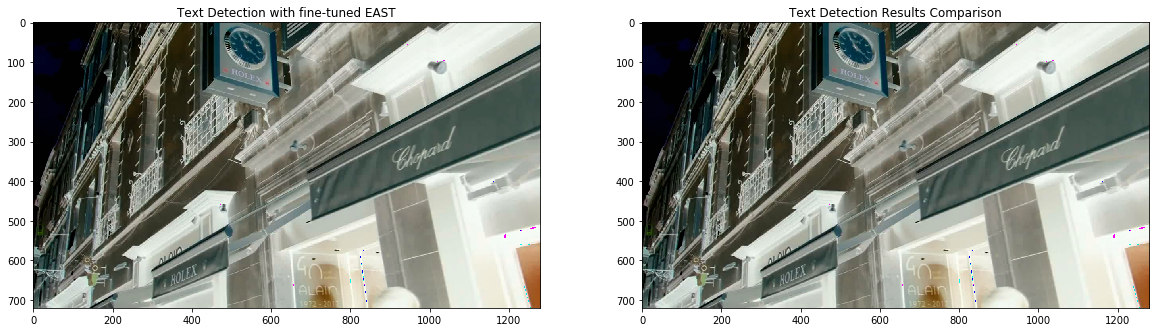

1 text boxes before nms, 0 text boxes after nms
9 text boxes before nms, 1 text boxes after nms
5 text boxes before nms, 0 text boxes after nms
6 text boxes before nms, 0 text boxes after nms
15 text boxes before nms, 1 text boxes after nms
5 text boxes before nms, 1 text boxes after nms
19 text boxes before nms, 1 text boxes after nms
16 text boxes before nms, 1 text boxes after nms
8 text boxes before nms, 1 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_39_2_3
24 text boxes before nms, 3 text boxes after nms
> <ipython-input-12-ca36729d110c>(169)main()
-> import pdb; pdb.set_trace()
(Pdb) c


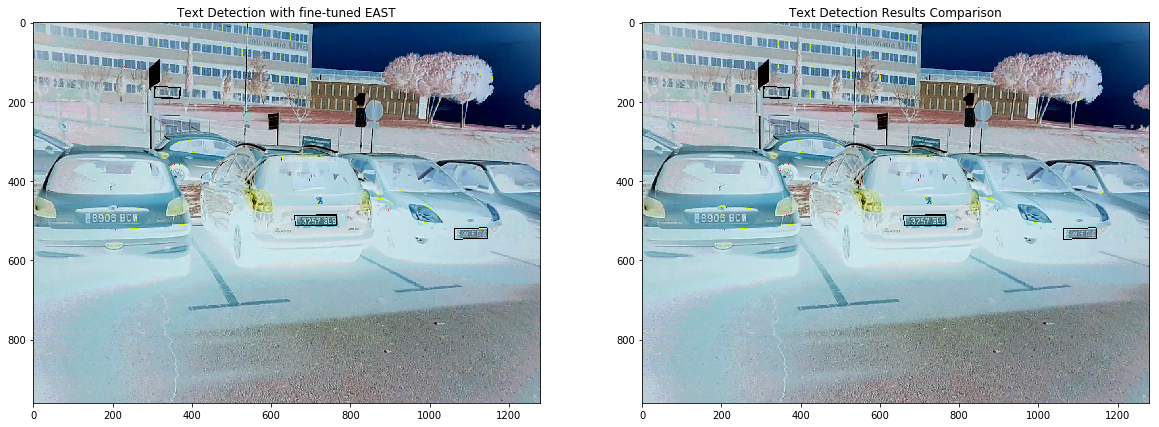

14 text boxes before nms, 2 text boxes after nms
34 text boxes before nms, 3 text boxes after nms
19 text boxes before nms, 3 text boxes after nms
28 text boxes before nms, 4 text boxes after nms
32 text boxes before nms, 4 text boxes after nms
32 text boxes before nms, 3 text boxes after nms
36 text boxes before nms, 4 text boxes after nms
30 text boxes before nms, 3 text boxes after nms
18 text boxes before nms, 2 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_9_1_1
> <ipython-input-12-ca36729d110c>(170)main()
-> plt.show()
(Pdb) c


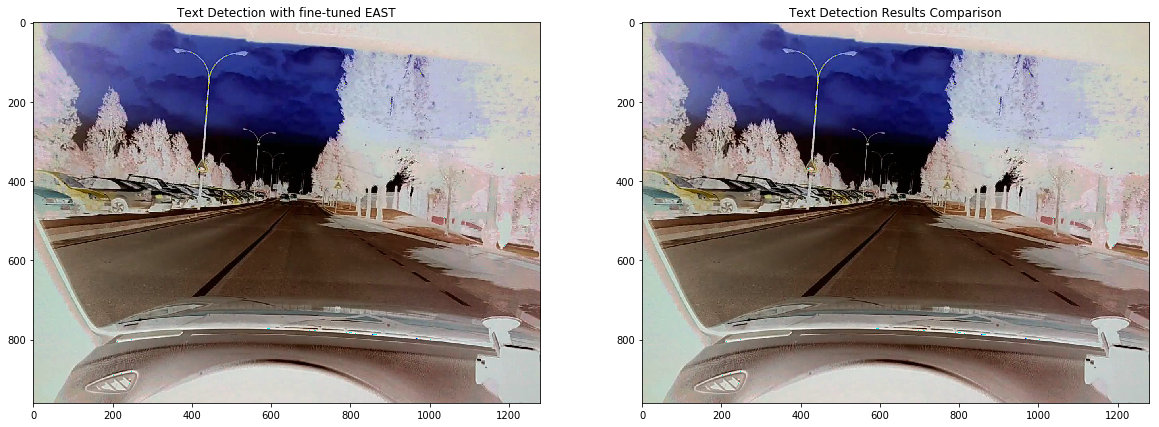

1 text boxes before nms, 0 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_22_5_1
21 text boxes before nms, 1 text boxes after nms
> <ipython-input-12-ca36729d110c>(169)main()
-> import pdb; pdb.set_trace()
(Pdb) c


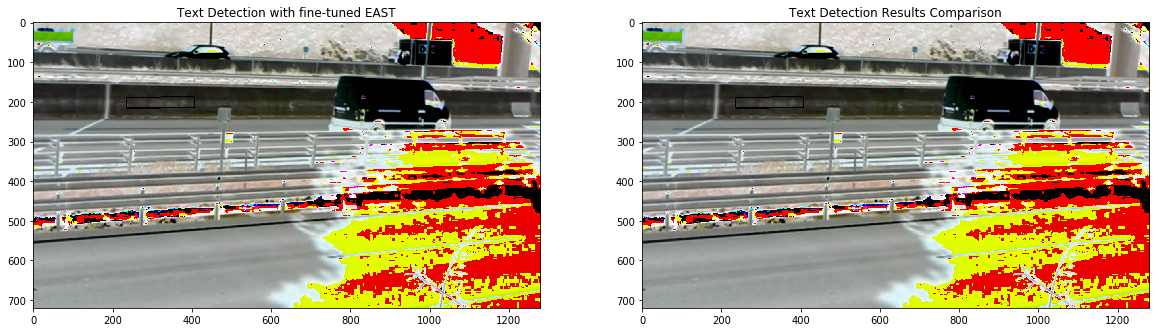

26 text boxes before nms, 1 text boxes after nms
25 text boxes before nms, 1 text boxes after nms
25 text boxes before nms, 1 text boxes after nms
22 text boxes before nms, 1 text boxes after nms
25 text boxes before nms, 1 text boxes after nms
21 text boxes before nms, 1 text boxes after nms
19 text boxes before nms, 1 text boxes after nms
22 text boxes before nms, 1 text boxes after nms
20 text boxes before nms, 1 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_48_6_4
164 text boxes before nms, 3 text boxes after nms
> <ipython-input-12-ca36729d110c>(170)main()
-> plt.show()
(Pdb) disable 1
*** Breakpoint number 1 out of range
(Pdb) disable 0
*** Breakpoint 0 already deleted
(Pdb) c


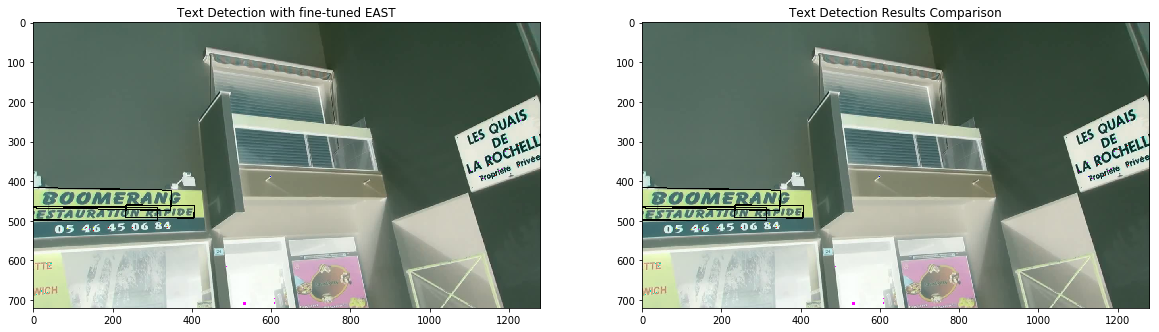

121 text boxes before nms, 3 text boxes after nms
162 text boxes before nms, 4 text boxes after nms
180 text boxes before nms, 4 text boxes after nms
117 text boxes before nms, 2 text boxes after nms
163 text boxes before nms, 2 text boxes after nms
158 text boxes before nms, 2 text boxes after nms
156 text boxes before nms, 2 text boxes after nms
103 text boxes before nms, 2 text boxes after nms
165 text boxes before nms, 3 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_30_2_3
68 text boxes before nms, 5 text boxes after nms
> <ipython-input-12-ca36729d110c>(169)main()
-> import pdb; pdb.set_trace()
(Pdb) c


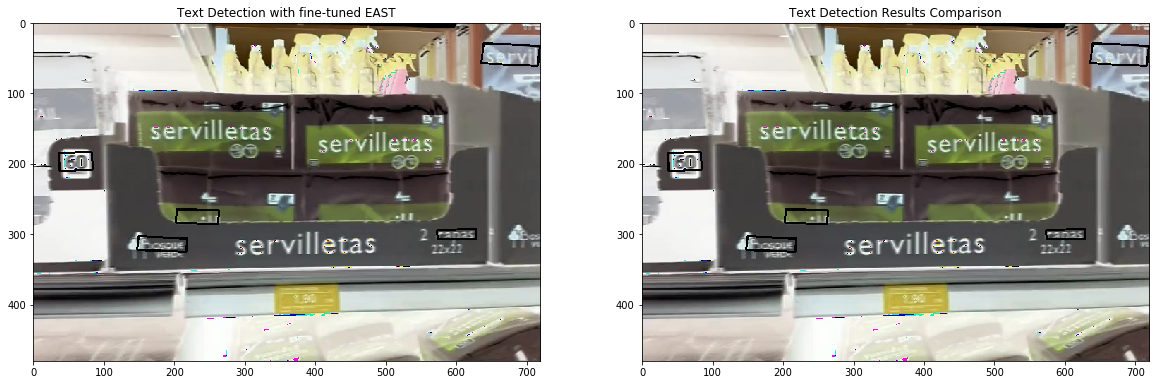

83 text boxes before nms, 5 text boxes after nms
85 text boxes before nms, 6 text boxes after nms
84 text boxes before nms, 6 text boxes after nms
73 text boxes before nms, 6 text boxes after nms
95 text boxes before nms, 5 text boxes after nms
106 text boxes before nms, 5 text boxes after nms
84 text boxes before nms, 5 text boxes after nms
106 text boxes before nms, 5 text boxes after nms
92 text boxes before nms, 4 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_5_3_2
> <ipython-input-12-ca36729d110c>(170)main()
-> plt.show()
(Pdb) c


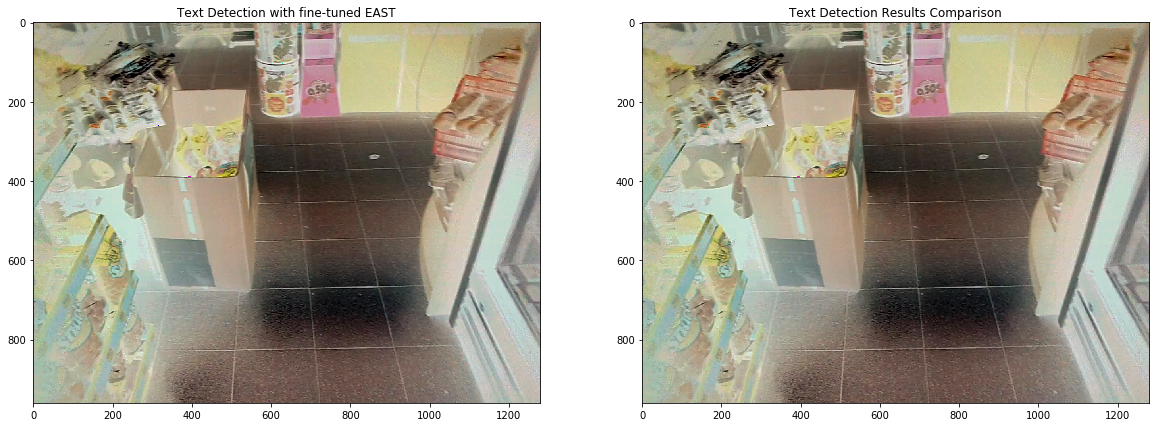

1 text boxes before nms, 0 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_17_3_1
64 text boxes before nms, 8 text boxes after nms
> <ipython-input-12-ca36729d110c>(169)main()
-> import pdb; pdb.set_trace()
(Pdb) c


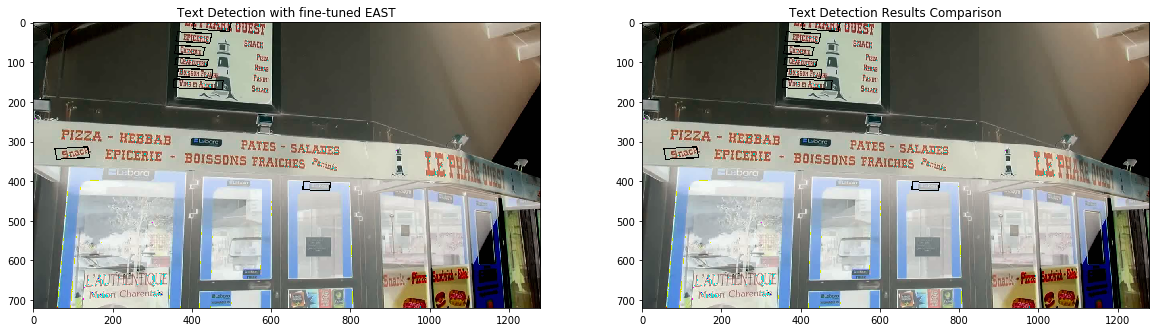

58 text boxes before nms, 7 text boxes after nms
43 text boxes before nms, 5 text boxes after nms
63 text boxes before nms, 8 text boxes after nms
61 text boxes before nms, 8 text boxes after nms
58 text boxes before nms, 8 text boxes after nms
44 text boxes before nms, 6 text boxes after nms
56 text boxes before nms, 6 text boxes after nms
63 text boxes before nms, 8 text boxes after nms
55 text boxes before nms, 7 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_35_2_3
113 text boxes before nms, 5 text boxes after nms
> <ipython-input-12-ca36729d110c>(170)main()
-> plt.show()
(Pdb) c


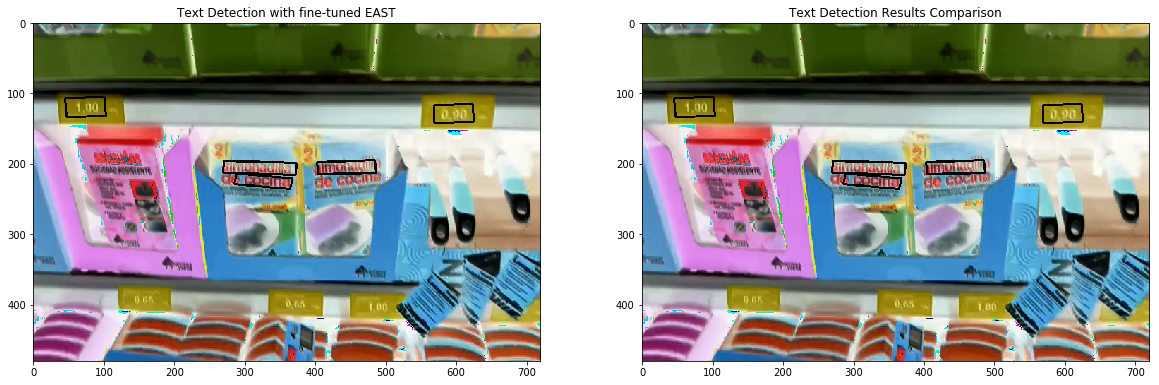

86 text boxes before nms, 8 text boxes after nms
123 text boxes before nms, 7 text boxes after nms
125 text boxes before nms, 9 text boxes after nms
150 text boxes before nms, 9 text boxes after nms
153 text boxes before nms, 9 text boxes after nms
160 text boxes before nms, 8 text boxes after nms
164 text boxes before nms, 9 text boxes after nms
183 text boxes before nms, 9 text boxes after nms
165 text boxes before nms, 8 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_6_3_2
127 text boxes before nms, 0 text boxes after nms
> <ipython-input-12-ca36729d110c>(169)main()
-> import pdb; pdb.set_trace()
(Pdb) c


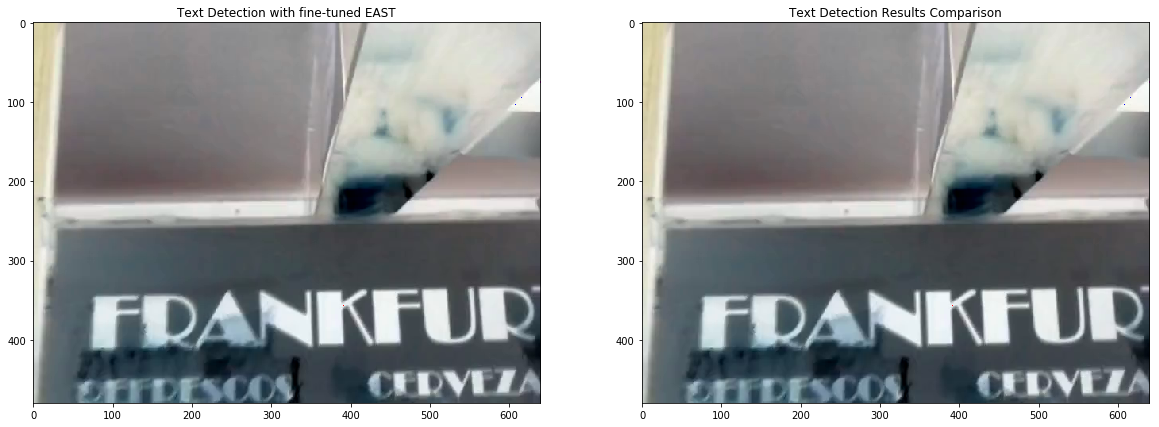

83 text boxes before nms, 0 text boxes after nms
268 text boxes before nms, 0 text boxes after nms
386 text boxes before nms, 1 text boxes after nms
538 text boxes before nms, 2 text boxes after nms
505 text boxes before nms, 3 text boxes after nms
604 text boxes before nms, 3 text boxes after nms
726 text boxes before nms, 4 text boxes after nms
853 text boxes before nms, 4 text boxes after nms
918 text boxes before nms, 4 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_55_3_2
319 text boxes before nms, 1 text boxes after nms
> <ipython-input-12-ca36729d110c>(170)main()
-> plt.show()
(Pdb) c


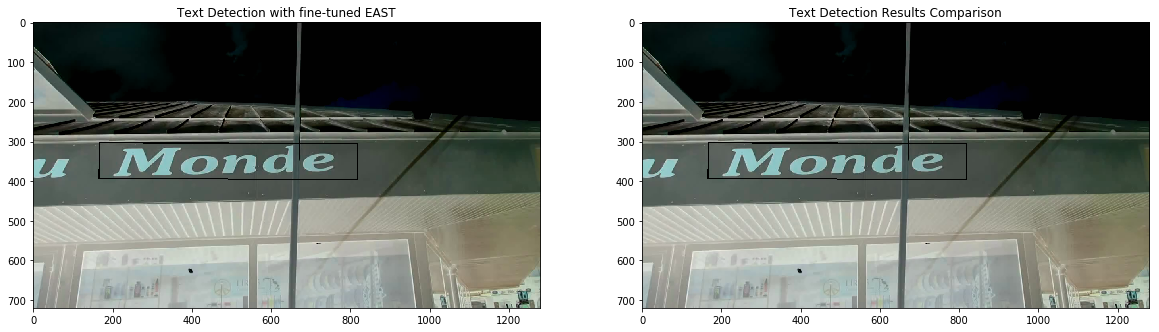

318 text boxes before nms, 1 text boxes after nms
323 text boxes before nms, 1 text boxes after nms
337 text boxes before nms, 1 text boxes after nms
336 text boxes before nms, 1 text boxes after nms
346 text boxes before nms, 1 text boxes after nms
391 text boxes before nms, 1 text boxes after nms
385 text boxes before nms, 1 text boxes after nms
346 text boxes before nms, 1 text boxes after nms
324 text boxes before nms, 1 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_34_2_3
> <ipython-input-12-ca36729d110c>(169)main()
-> import pdb; pdb.set_trace()
(Pdb) c


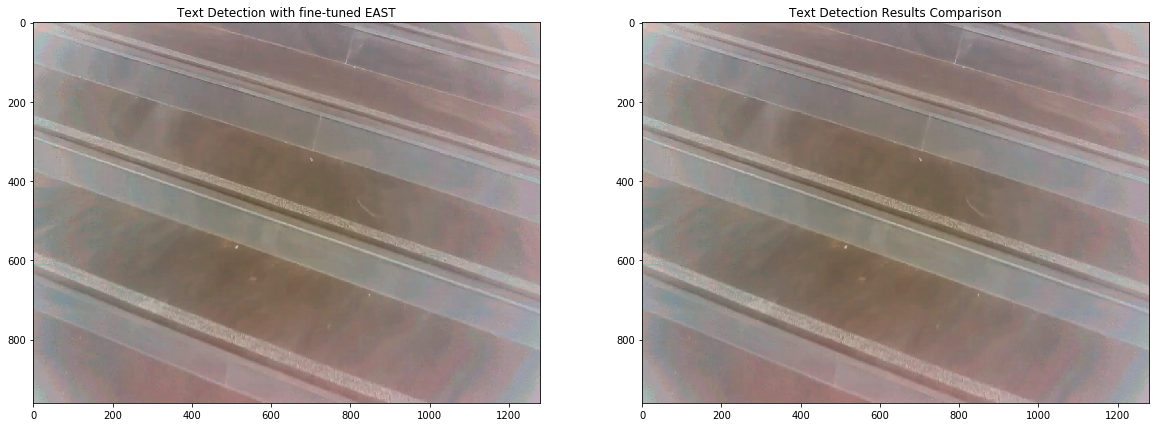

4 text boxes before nms, 0 text boxes after nms
17 text boxes before nms, 1 text boxes after nms
2 text boxes before nms, 0 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_11_4_1
> <ipython-input-12-ca36729d110c>(170)main()
-> plt.show()
(Pdb) c


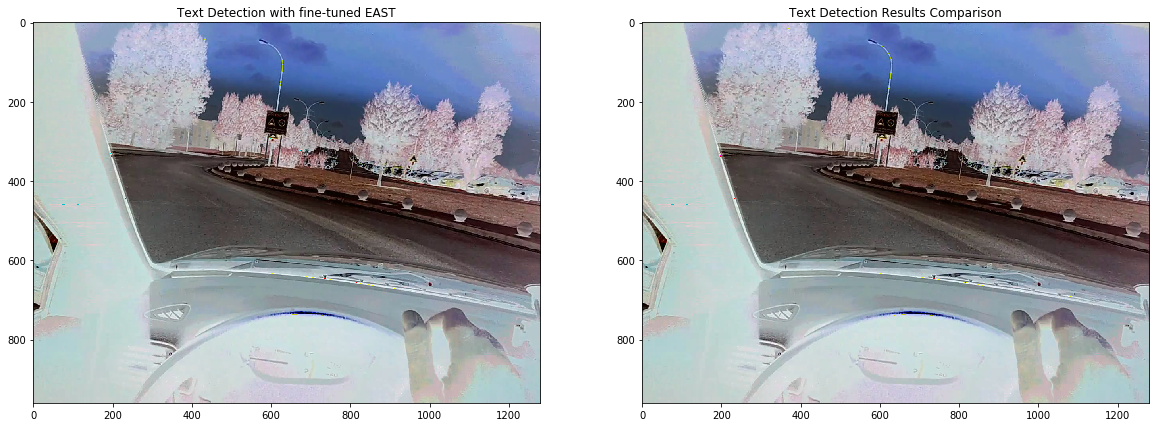

3 text boxes before nms, 1 text boxes after nms
4 text boxes before nms, 0 text boxes after nms
3 text boxes before nms, 1 text boxes after nms
5 text boxes before nms, 1 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_20_5_1
75 text boxes before nms, 2 text boxes after nms
> <ipython-input-12-ca36729d110c>(169)main()
-> import pdb; pdb.set_trace()
(Pdb) c


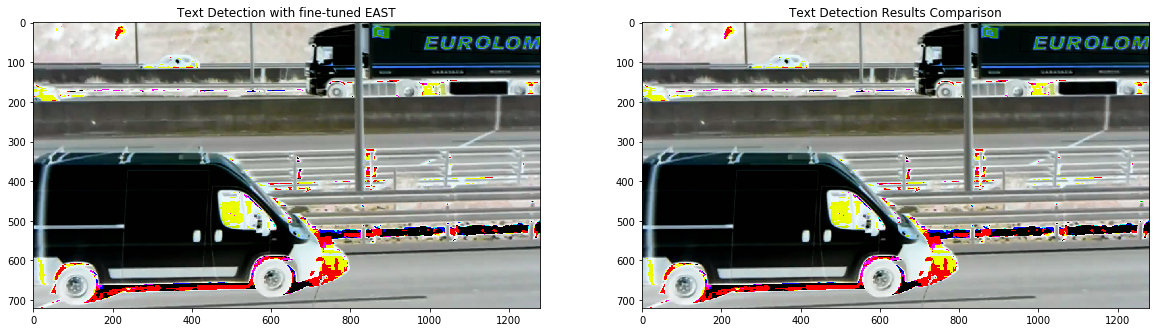

94 text boxes before nms, 2 text boxes after nms
101 text boxes before nms, 2 text boxes after nms
99 text boxes before nms, 2 text boxes after nms
106 text boxes before nms, 2 text boxes after nms
91 text boxes before nms, 2 text boxes after nms
76 text boxes before nms, 2 text boxes after nms
88 text boxes before nms, 3 text boxes after nms
104 text boxes before nms, 5 text boxes after nms
82 text boxes before nms, 3 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_49_6_4
> <ipython-input-12-ca36729d110c>(170)main()
-> plt.show()
(Pdb) c


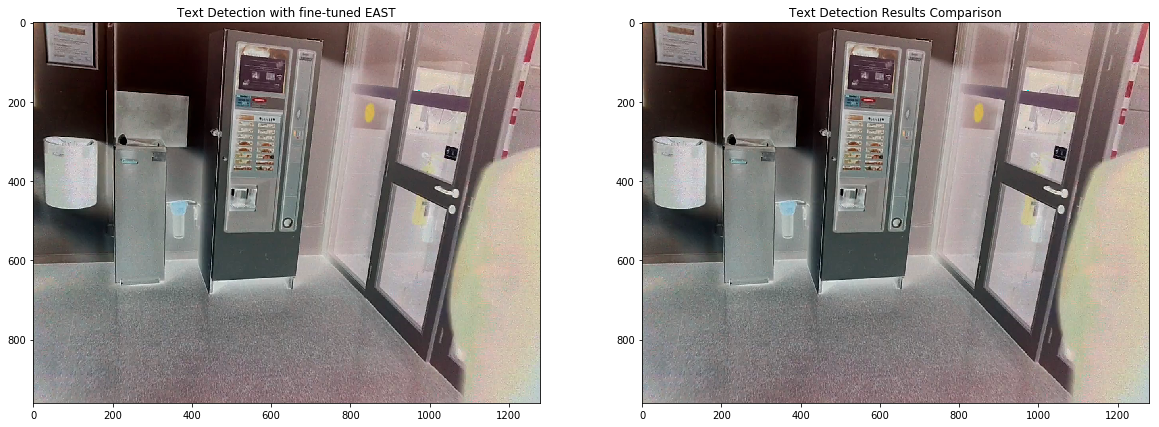

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_15_4_1
> <ipython-input-12-ca36729d110c>(169)main()
-> import pdb; pdb.set_trace()
(Pdb) c


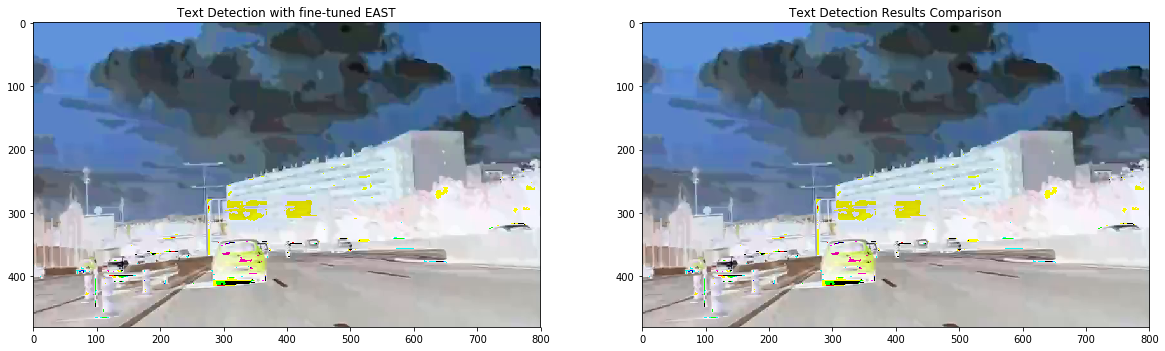

16 text boxes before nms, 0 text boxes after nms
31 text boxes before nms, 0 text boxes after nms
40 text boxes before nms, 0 text boxes after nms
44 text boxes before nms, 0 text boxes after nms
42 text boxes before nms, 0 text boxes after nms
39 text boxes before nms, 0 text boxes after nms
43 text boxes before nms, 0 text boxes after nms
41 text boxes before nms, 0 text boxes after nms
26 text boxes before nms, 0 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_23_5_2
> <ipython-input-12-ca36729d110c>(170)main()
-> plt.show()
(Pdb) c


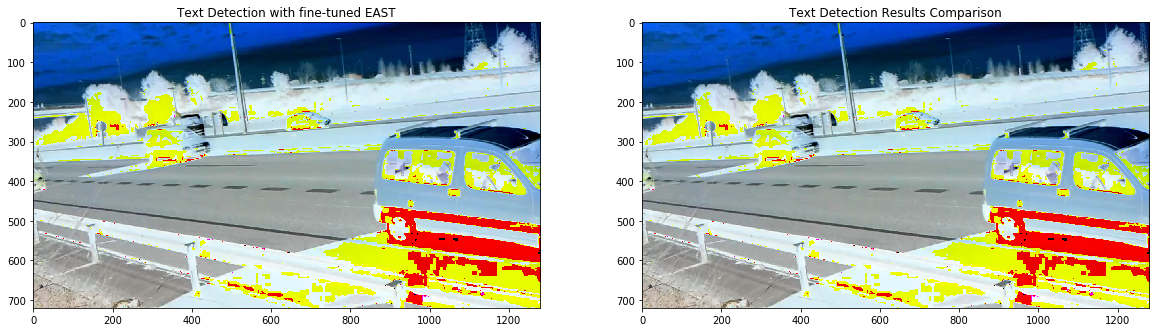

9 text boxes before nms, 0 text boxes after nms
23 text boxes before nms, 0 text boxes after nms
12 text boxes before nms, 0 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_43_6_4
1 text boxes before nms, 0 text boxes after nms
> <ipython-input-12-ca36729d110c>(169)main()
-> import pdb; pdb.set_trace()
(Pdb) c


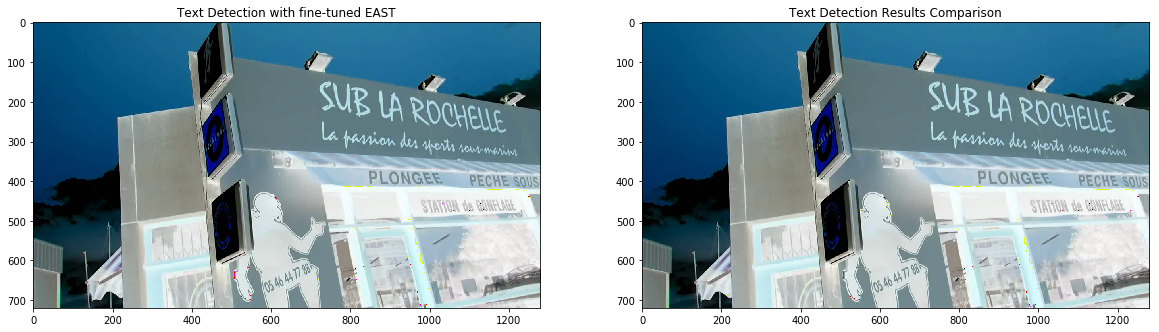

3 text boxes before nms, 0 text boxes after nms
20 text boxes before nms, 0 text boxes after nms
44 text boxes before nms, 0 text boxes after nms
49 text boxes before nms, 0 text boxes after nms
50 text boxes before nms, 0 text boxes after nms
75 text boxes before nms, 1 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_38_2_3
> <ipython-input-12-ca36729d110c>(170)main()
-> plt.show()
(Pdb) c


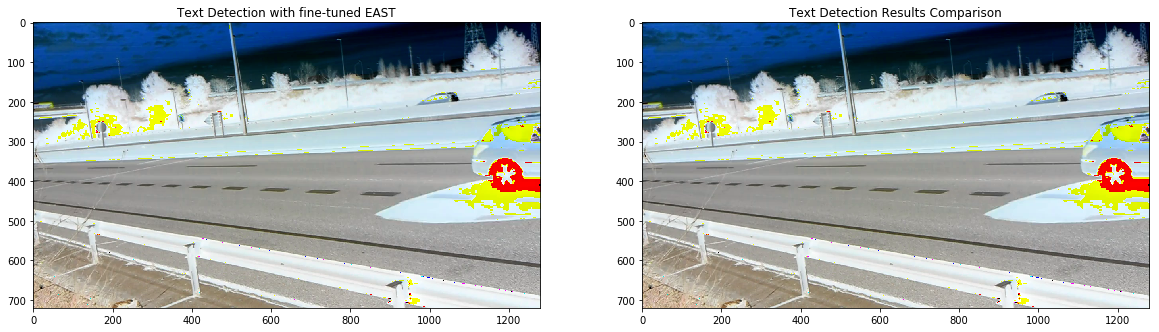

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_44_6_4
> <ipython-input-12-ca36729d110c>(169)main()
-> import pdb; pdb.set_trace()
(Pdb) c


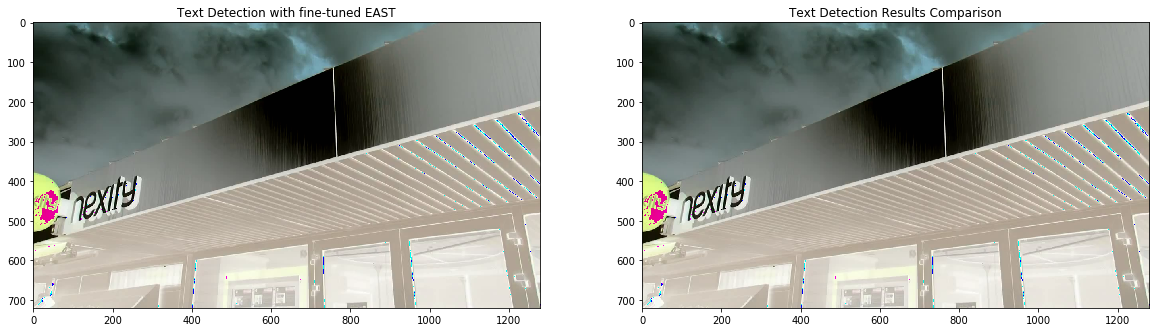

17 text boxes before nms, 0 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_32_2_3
> <ipython-input-12-ca36729d110c>(170)main()
-> plt.show()
(Pdb) c


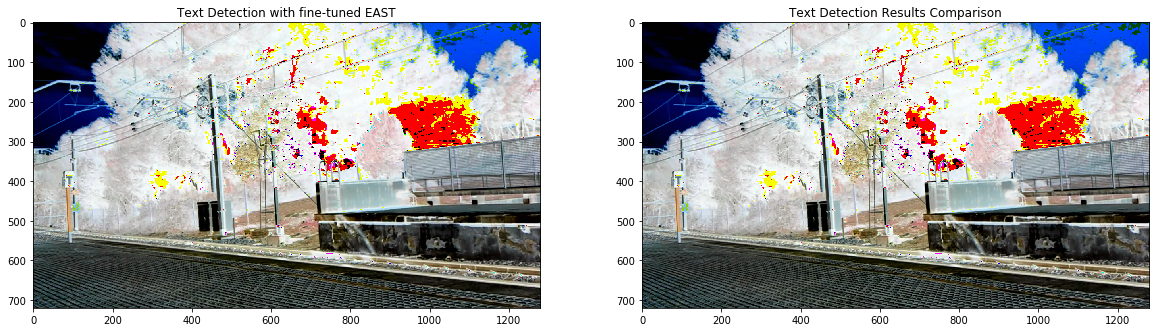

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_53_7_4
> <ipython-input-12-ca36729d110c>(169)main()
-> import pdb; pdb.set_trace()
(Pdb) c


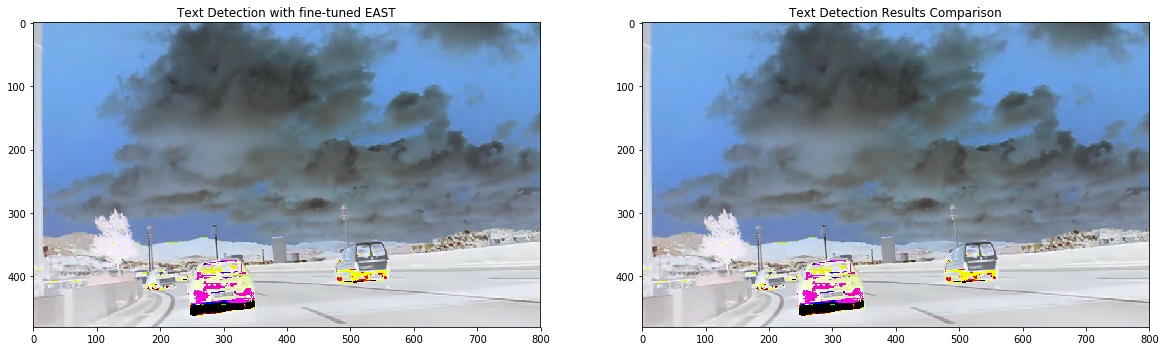

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_24_5_2
10 text boxes before nms, 0 text boxes after nms
> <ipython-input-12-ca36729d110c>(170)main()
-> plt.show()
(Pdb) c


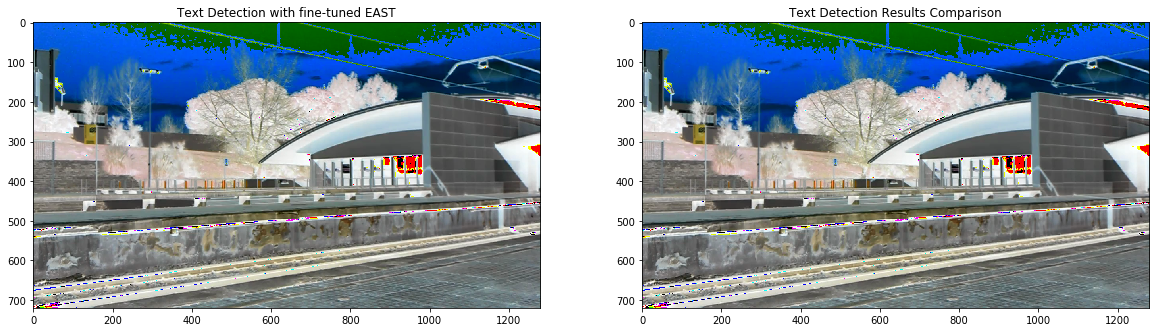

7 text boxes before nms, 0 text boxes after nms
2 text boxes before nms, 0 text boxes after nms
2 text boxes before nms, 0 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_50_7_4
5 text boxes before nms, 1 text boxes after nms
> <ipython-input-12-ca36729d110c>(169)main()
-> import pdb; pdb.set_trace()
(Pdb) c


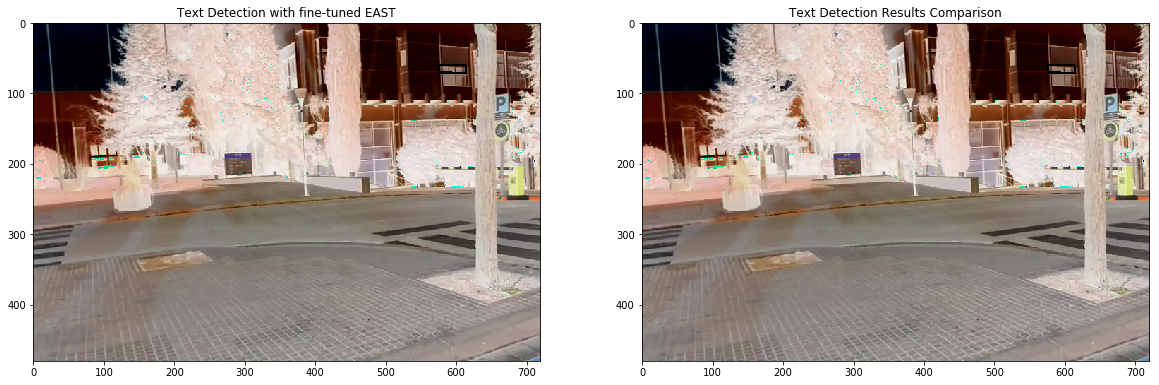

5 text boxes before nms, 1 text boxes after nms
8 text boxes before nms, 1 text boxes after nms
9 text boxes before nms, 1 text boxes after nms
10 text boxes before nms, 1 text boxes after nms
10 text boxes before nms, 1 text boxes after nms
9 text boxes before nms, 1 text boxes after nms
10 text boxes before nms, 1 text boxes after nms
9 text boxes before nms, 1 text boxes after nms
10 text boxes before nms, 1 text boxes after nms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_1_1_2
here is the precision
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
here is the recall
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
here is the f-score
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
['Video_39_2_3', 'Video_9_1_1', 'Video_22_5_1', 'Video_48_6_4', 'V

In [12]:
%matplotlib inline
def main():
    checkpoint_path = '/work/cascades/lxiaol9/ARC/EAST/checkpoints/LSTM_east/'
    idname1 = '20181005-192003'
    idname2 = '-26003'
    test_data_path = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2015/test/'
    save_path = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2015/test_results_lstm/'
    filename = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2015/test/Video_6_3_2.mp4'
    idx = 0  # initial frame number
    config = get_config(FLAGS)
    config.batch_size = 1
    config.num_layers = 3
    config.num_steps  = 10
    #>>>>>>>>>>>>>>>>>>>>>>Sort test video>>>>>>>>>>>>>>>>>>>>>>>>>>>#
    video_set = []
    for root, dirs, files in os.walk(test_data_path):
        for file in files:
            if file.endswith('.mp4'):
                video_set.append(os.path.splitext(file)[0])
    index = range(0, len(video_set))
    if not os.path.exists(checkpoint_path):
        raise RuntimeError(
            'Checkpoint `{}` not found'.format(checkpoint_path))

    logger.info('loading model')
    #>>>>>>>>>>>>>>>>>>>>>>> Loading Model >>>>>>>>>>>>>>>>>>>>>>>>>#
    gpu_options = tf.GPUOptions(allow_growth=True)
    input_images = tf.placeholder(tf.float32, shape=[None, None, None, 3], name='input_images')
    if FLAGS.running_count == 0:
        reuse_variables=False
    else:
        reuse_variables=True
    with tf.name_scope("Val"):
        # use placeholder to stand for input and targets
        initializer = tf.random_normal_initializer()
        x_val = tf.placeholder(tf.float32, shape=[None, config.num_steps, None, None, 3])
        model = ArrayModel(False, config, x_val, reuse_variables=reuse_variables, initializer=initializer)
        FLAGS.running_count+=1
    var_total = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    #>>>>>>>>>>>>>>>>>>>>>>>> restore the model from weights>>>>>>>>#
    soft_placement = False
    saver = tf.train.Saver()
    config_proto = tf.ConfigProto(allow_soft_placement = soft_placement)
    # with sv.managed_session(config=config_proto) as session:
    #     if FLAGS.restore:
    #         print('continue training from previous checkpoint')
    #         # ckpt = tf.train.latest_checkpoint(FLAGS.checkpoints_path)
    #         ckpt = checkpoint_path + idname1 + '/' + idname2
    #         sv.saver.restore(session, ckpt)
    model_path = checkpoint_path + idname1 + '/' + idname2
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    logger.info('Restore from {}'.format(model_path))
    saver.restore(sess, model_path)
    #>>>>>>>>>>>>>>>>>>>>>>Start evaluation>>>>>>>>>>>>>>>>>>>>>>>>>#
    P_test = []
    R_test = []
    f1_test = []
    for k in index:
        P_video = []
        R_video = []
        f1_video = []
        video_save = save_path + video_set[k] + idname1 + '_' + idname2 + '.avi'
        t_start = time.time()
        # sort up all the paths
        xml_solo_path = test_data_path + video_set[k]
        raw_video_path = test_data_path + video_set[k]+'.mp4'
        cap = cv2.VideoCapture(raw_video_path)
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        cnt_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        out = cv2.VideoWriter(video_save, cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
        # 1. load both polys and tags; 2. generate geo maps(the format of polys and tags need to match)
#         polys_array_list, tags_array_list, id_list_list, frame_num = load_annotations_solo(xml_solo_path, \
#                     1, cnt_frame, frame_width, frame_height)
        #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>loop over frames in the time steps >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        for i in range(int(cnt_frame/config.num_steps)):
            data_seq = np.zeros((1, config.num_steps, 512, 512, 3), dtype=np.float32)
            data_original = np.zeros((1, config.num_steps, frame_height, frame_width, 3), dtype=np.float32)
            for m in range(config.num_steps):
                ret, frame = cap.read()
                im_resized = cv2.resize(frame, (int(512), int(512)))
#                 im_resized = frame[0:512, 0:512, :]
                data_original[0, m, :, :,:] = frame
                data_seq[0, m, :, : , :] = im_resized
            #>>>>>>>>>>>>>>>>>>>>>>>>>Now it's time to run the model>>>>>>>>>>>>>>>>>>>>>>>>>>
            state = sess.run(model.initial_state)
            # tensors dict to run
            fetches = {
                    "score_map": model.score_map_set,
                    "geometry_map": model.geometry_set
                    }
            feed_dict = {}
            feed_dict[model.input_data] = data_seq
            for i, (c, h) in enumerate(model.initial_state):
                feed_dict[c] = state[i].c
                feed_dict[h] = state[i].h
            timer = collections.OrderedDict([
                ('net', 0),
                ('restore', 0),
                ('nms', 0)
            ])
            start = time.time()
            vals = sess.run(fetches, feed_dict=feed_dict)
            timer['net'] = time.time() - start
            #>>>>>>>>>>>>>>>>>>>>>>>>Okay!!!We could evalute the results now>>>>>>>>>>>>>>>>>>>
            for j in range(config.num_steps):
                rtparams = collections.OrderedDict()
                rtparams['start_time'] = datetime.datetime.now().isoformat()
                rtparams['image_size'] = '{}x{}'.format(frame_width, frame_height)
                # im_resized, (ratio_h, ratio_w) = resize_image(img)
                ratio_h, ratio_w = 512/frame_height, 512/frame_width
                rtparams['working_size'] = '{}x{}'.format(512, 512)
                # results refinement via NMS
                score = vals["score_map"][j]
                geometry = vals["geometry_map"][j]
                boxes, timer = detect(score_map=score, geo_map=geometry, timer=timer)
                logger.info('net {:.0f}ms, restore {:.0f}ms, nms {:.0f}ms'.format(
                    timer['net']*1000, timer['restore']*1000, timer['nms']*1000))
                if boxes is not None:
                    scores = boxes[:,8].reshape(-1)
                    boxes = boxes[:, :8].reshape((-1, 4, 2))
                    boxes[:, :, 0] /= ratio_w
                    boxes[:, :, 1] /= ratio_h

                duration = time.time() - start
                timer['overall'] = duration
                logger.info('[timing] {}'.format(duration))
                text_lines = []
                if boxes is not None:
                    text_lines = []
                    for box, score in zip(boxes, scores):
                        box = sort_poly(box.astype(np.int32))
                        if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3]-box[0]) < 5:
                            continue
                        tl = collections.OrderedDict(zip(
                            ['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3'],
                            map(float, box.flatten())))
                        tl['score'] = float(score)
                        text_lines.append(tl)
                pred = {
                    'text_lines': text_lines,
                    'rtparams': rtparams,
                    'timing': timer,
                }
#                 text_polys, text_tags = polys_array_list[i*10+j], tags_array_list[i*10+j]
#                 text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (frame_height, frame_width))
                # out.write(new_img)
                #>>>>>>>>>>>>>>>>>>>>>>>>Evaluation>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#                 targets = text_polys
#                 precision, recall, f1 = eval_single_frame(targets, pred)
                precision, recall, f1 = 0, 0, 0
                P_video.append(precision)
                R_video.append(recall)
                f1_video.append(f1)
                img = data_original[0, j, :, :,:]
                new_img = draw_illu(img.copy(), pred)
#                 new_img1 = draw_illu_gt(new_img.copy(), targets, precision, recall, f1)
                out.write(new_img)
                # using for pre-testing
                FLAGS.vis = True 
                if j == 0 and FLAGS.vis:
                    fig1 = plt.figure(figsize=(20, 10))
                    fig1.add_subplot(1, 2, 1)
                    plt.imshow(new_img )
                    plt.title("Text Detection with fine-tuned EAST")
                    fig1.add_subplot(1, 2, 2)
                    plt.imshow(new_img)
                    plt.title('Text Detection Results Comparison')
                    import pdb; pdb.set_trace()
                    plt.show()
                    
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            else:
                break
            # evaluation on ret and gt
        P_test.append(np.array(P_video, dtype=np.float32))
        R_test.append(np.array(R_video, dtype=np.float32))
        f1_test.append(np.array(f1_video, dtype=np.float32))
        print(P_video)
        print(R_video)
        print(f1_video)
        print("testing results are P:{}, R:{}, F1:{} on ".format(sum(P_video)/cnt_frame, sum(R_video)/cnt_frame, sum(f1_video)/cnt_frame)+video_set[k])
        cap.release()
        out.release()                # results refinement via NMS
    print('here is the precision')
    for item in P_test:
        print(np.mean(item))
    print('here is the recall')
    for item in R_test:
        print(np.mean(item))
    print('here is the f-score')
    for item in f1_test:
        print(np.mean(item))
    print(video_set)
if __name__ == '__main__':
    main()